## 1. Importación de las bibliotecas necesarias

In [ ]:
# Instalar geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

In [1]:
import ee
import os
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import geemap as emap
import geemap.colormaps as cm
Map = emap.Map()
Map.add_basemap('ROADMAP')
ee.Initialize()

## 2. Máximo NDVI entre 2000-2020

### 2.1 Algoritmo para procesar la media NDVI y SRTM

In [2]:
#region = ee.FeatureCollection('users/geoyons/tugee/LimaProv')
region = ee.FeatureCollection('users/geoyons/tugee/Lomas_Modis')

#Lomas_del_Norte, Lomas_del_Centro_Norte, Lomas_del_Oeste, Lomas_del_Sur, Lomas_del_Centro_Sur
#region = ee.FeatureCollection('users/geoyons/tugee/corredEcol')\
                  #.filterMetadata('CorredEcol','equals','Lomas_del_Sur') 

srtm = ee.Image("USGS/SRTMGL1_003").clip(region)
#maskDEM = SRTM.gte(150).And(SRTM.lte(1800))
paletteDem = cm.palettes.dem
paletteAspect = cm.palettes.rainbow
paletteSlope = cm.palettes.Spectral

# Definimos la coleccion
collection = 'MODIS/006/MOD13Q1'

bands = ['NDVI']

def maskSQA(image):
    mask = image.select('SummaryQA').eq(0).Or(image.select('SummaryQA').eq(1))
    imageMask = image.updateMask(mask)
    return imageMask

ini_date = ['2000-07-01','2001-07-01','2002-07-01','2003-07-01','2004-07-01','2005-07-01','2006-07-01','2007-07-01',
           '2008-07-01','2009-07-01','2010-07-01','2011-07-01','2012-07-01','2013-07-01','2014-07-01','2015-07-01',
           '2016-07-01','2017-07-01','2018-07-01','2019-07-01','2020-07-01']

end_date = ['2000-10-30','2001-10-30','2002-10-30','2003-10-30','2004-10-30','2005-10-30','2006-10-30','2007-10-30',
           '2008-10-30','2009-10-30','2010-10-30','2011-10-30','2012-10-30','2013-10-30','2014-10-30','2015-10-30',
           '2016-10-30','2017-10-30','2018-10-30','2019-10-30','2020-10-30']

ndviM = ee.List([])

for i in np.arange(0, len(ini_date), 1):
    
    col = ee.ImageCollection(collection)\
        .filterDate(ini_date[i],end_date[i])\
        .filterBounds(region)\
        .map(maskSQA)\
        .reduce(ee.Reducer.max())\
        .select([0], bands)
    freq = col.select('NDVI').divide(10000).clip(region)
    ndviM = ndviM.add(freq)

# Coleccion de imagenes
ndvi = ee.ImageCollection.fromImages(ndviM).reduce(ee.Reducer.mean())

# Definimos los parametros de visualizacion
visParams = {
  'bands': ['NDVI_mean'],
  'min': 0,
  'max': 0.6,
  'palette': ['FFFFFF','CC9966','CC9900','996600', '33CC00', '009900','006600']
}

orientacion = ee.Terrain.aspect(ee.Image("USGS/SRTMGL1_003")).clip(region)
pendiente = ee.Terrain.slope(ee.Image("USGS/SRTMGL1_003")).clip(region)
Map.addLayer(srtm, {'min': 20,'max': 2000, 'palette': paletteDem}, 'DEM', True)
Map.addLayer(orientacion, {'min': 0,'max': 360, 'palette': paletteAspect}, 'ASPECT', True)
Map.addLayer(pendiente, {'min': 0,'max': 50, 'palette': paletteSlope}, 'SLOPE', True)
Map.addLayer(ndvi, visParams, 'NDVI', True)
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [11]:
# Descargar directamente a Google Drive
task = ee.batch.Export.image(srtm.divide(1), 
                              'SRTM_RegionLomas', 
                              {'region': region.geometry(),
                               'scale': 250,
                               'maxPixels': 1e13,
                               'folder': 'MOD13Q1_NDVI',
                               'fileFormat': 'GeoTIFF',
                               'crs': 'EPSG:4326'})
task.start()
# Descargar directamente a Google Drive
task = ee.batch.Export.image(ndvi.divide(1), 
                              'NDVI_MEDIA_RegionLomas', 
                              {'region': region.geometry(),
                               'scale': 250,
                               'maxPixels': 1e13,
                               'folder': 'MOD13Q1_NDVI',
                               'fileFormat': 'GeoTIFF',
                               'crs': 'EPSG:4326'})
task.start()
task = ee.batch.Export.image(orientacion.divide(1), 
                              'ORIENTACION_RegionLomas', 
                              {'region': region.geometry(),
                               'scale': 250,
                               'maxPixels': 1e13,
                               'folder': 'MOD13Q1_NDVI',
                               'fileFormat': 'GeoTIFF',
                               'crs': 'EPSG:4326'})
task.start()
task = ee.batch.Export.image(pendiente.divide(1), 
                              'PENDIENTE_RegionLomas', 
                              {'region': region.geometry(),
                               'scale': 250,
                               'maxPixels': 1e13,
                               'folder': 'MOD13Q1_NDVI',
                               'fileFormat': 'GeoTIFF',
                               'crs': 'EPSG:4326'})
task.start()

### 2.2 Correlación entre NDVI y SRTM

In [58]:
%matplotlib inline
path = r'F:\ConsultoriaPNUD\Data\MapLomas\MOD13Q1_NDVI'
os.chdir(path)

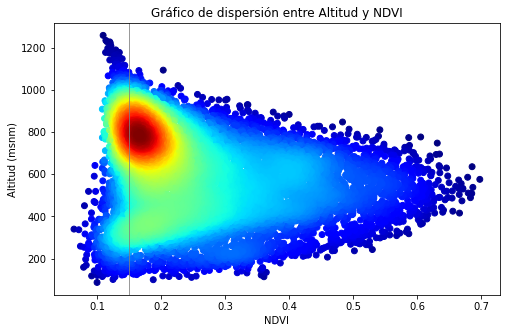

In [3]:
srtm = rasterio.open('SRTM_RegionLomas.tif').read()
ndvi = rasterio.open('NDVI_MEDIA_RegionLomas.tif').read()

n = ndvi.ravel()
m = srtm.ravel()
dataFrame = pd.DataFrame({'x':n, 'y':m})
df = dataFrame.dropna() # omite los NaN
df = df.loc[(df!=0).any(1)] # omite los 0

x = df.iloc[:,0].values
y = df.iloc[:,1].values

# Calcula la densidad de punto
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Ordena los puntos por densidad
idx = z.argsort()
xi, yi, zi = x[idx], y[idx], z[idx]

fig, axes = plt.subplots(figsize=(8,5))
axes.scatter(xi, yi, c=zi, s=35, cmap='jet')
axes.set_ylabel('Altitud (msnm)')
axes.set_xlabel('NDVI')
axes.set_title('Gráfico de dispersión entre Altitud y NDVI')
axes.axvline(x =0.15, color='grey', linewidth=0.8)
plt.show()
#plt.savefig('Grafico_de_dispersion_entre_Altitud_NDVI.png')

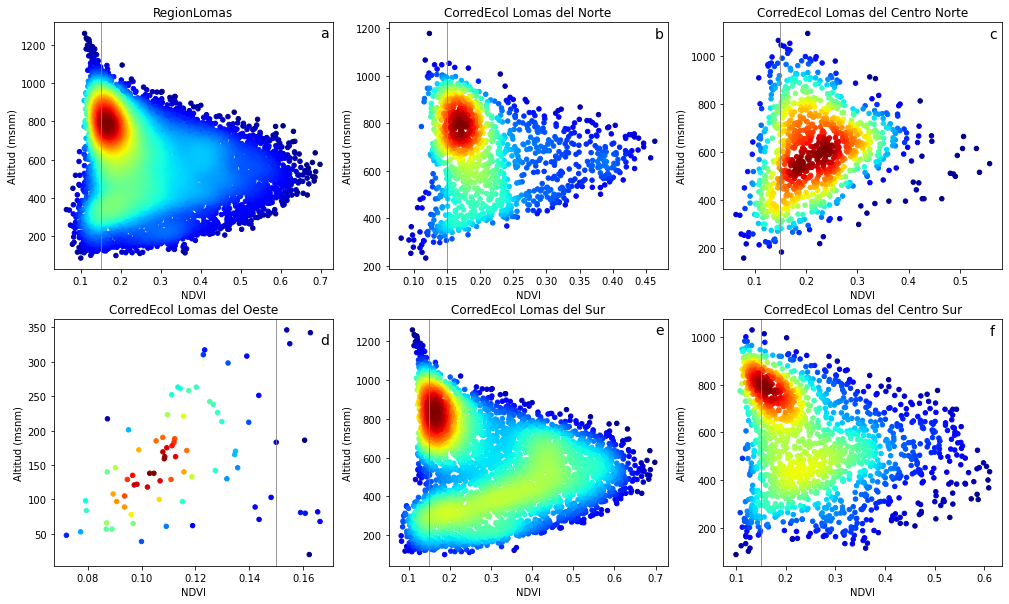

In [38]:
names = ['RegionLomas', 'CorredEcol_Lomas_del_Norte', 'CorredEcol_Lomas_del_Centro_Norte', 'CorredEcol_Lomas_del_Oeste', 
         'CorredEcol_Lomas_del_Sur', 'CorredEcol_Lomas_del_Centro_Sur']
letters = ['a', 'b', 'c', 'd', 'e', 'f']
fig = plt.figure(figsize=(17,10))
for i in np.arange(0, 6, 1):
    srtm = rasterio.open('SRTM_'+ names[i] + '.tif').read()
    ndvi = rasterio.open('NDVI_MEDIA_'+ names[i] + '.tif').read()

    n = ndvi.ravel()
    m = srtm.ravel()
    dataFrame = pd.DataFrame({'x':n, 'y':m})
    df = dataFrame.dropna() # omite los NaN
    df = df.loc[(df!=0).any(1)] # omite los 0

    x = df.iloc[:,0].values
    y = df.iloc[:,1].values

    # Calcula la densidad de punto
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Ordena los puntos por densidad
    idx = z.argsort()
    xi, yi, zi = x[idx], y[idx], z[idx]

    axes = fig.add_subplot(2,3,i+1)
    axes.scatter(xi, yi, c=zi, s=20, cmap='jet')
    axes.set_ylabel('Altitud (msnm)')
    axes.set_xlabel('NDVI')
    axes.set_title(names[i].replace("_", " "))
    axes.axvline(x =0.15, color='grey', linewidth=0.8)
    axes.text(np.nanmax(ndvi), np.nanmax(srtm)-20, letters[i], fontsize=14)
#plt.savefig('Grafico_de_dispersion_entre_Altitud_NDVI_PorRegion.png')

### 2.3 Correlación entre NDVI y Orientación

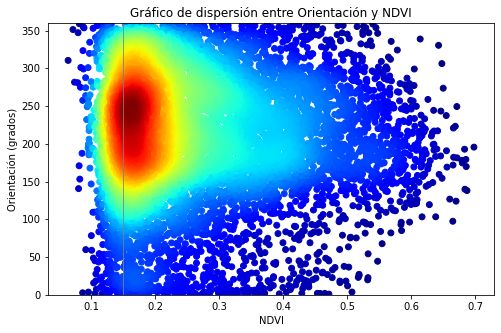

In [52]:
orien = rasterio.open('ORIENTACION_RegionLomas.tif').read()
ndvi = rasterio.open('NDVI_MEDIA_RegionLomas.tif').read()

n = ndvi.ravel()
m = orien.ravel()
dataFrame = pd.DataFrame({'x':n, 'y':m})
df = dataFrame.dropna()
df = df.loc[(df!=0).any(1)]

x = df.iloc[:,0].values
y = df.iloc[:,1].values

# Calcula la densidad de punto
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Ordena los puntos por densidad
idx = z.argsort()
xi, yi, zi = x[idx], y[idx], z[idx]

fig, axes = plt.subplots(figsize=(8,5))
axes.scatter(xi, yi, c=zi, s=35, cmap='jet')
axes.set_ylabel('Orientación (grados)')
axes.set_xlabel('NDVI')
axes.set_title('Gráfico de dispersión entre Orientación y NDVI')
axes.axvline(x =0.15, color='grey', linewidth=0.8)
axes.set_ylim(bottom=0, top=360)
plt.show()

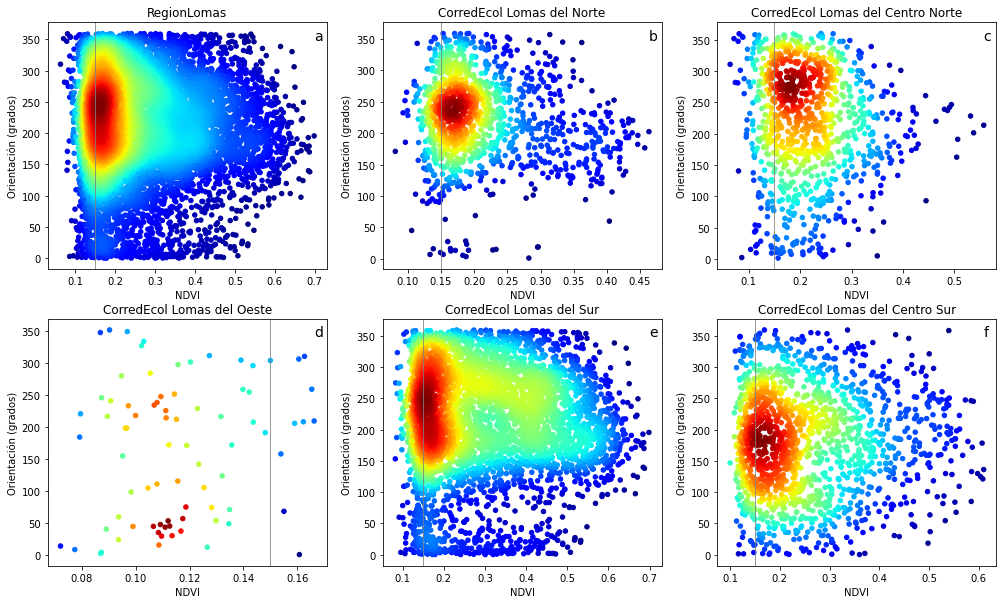

In [39]:
names = ['RegionLomas', 'CorredEcol_Lomas_del_Norte', 'CorredEcol_Lomas_del_Centro_Norte', 'CorredEcol_Lomas_del_Oeste', 
         'CorredEcol_Lomas_del_Sur', 'CorredEcol_Lomas_del_Centro_Sur']
letters = ['a', 'b', 'c', 'd', 'e', 'f']
fig = plt.figure(figsize=(17,10))
for i in np.arange(0, 6, 1):
    srtm = rasterio.open('ORIENTACION_'+ names[i] + '.tif').read()
    ndvi = rasterio.open('NDVI_MEDIA_'+ names[i] + '.tif').read()

    n = ndvi.ravel()
    m = srtm.ravel()
    dataFrame = pd.DataFrame({'x':n, 'y':m})
    df = dataFrame.dropna() # omite los NaN
    df = df.loc[(df!=0).any(1)] # omite los 0

    x = df.iloc[:,0].values
    y = df.iloc[:,1].values

    # Calcula la densidad de punto
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Ordena los puntos por densidad
    idx = z.argsort()
    xi, yi, zi = x[idx], y[idx], z[idx]

    axes = fig.add_subplot(2,3,i+1)
    axes.scatter(xi, yi, c=zi, s=20, cmap='jet')
    axes.set_ylabel('Orientación (grados)')
    axes.set_xlabel('NDVI')
    axes.set_title(names[i].replace("_", " "))
    axes.axvline(x =0.15, color='grey', linewidth=0.8)
    axes.text(np.nanmax(ndvi), np.nanmax(srtm)-10, letters[i], fontsize=14)
#plt.savefig('Grafico_de_dispersion_entre_ORIENTACION_NDVI_PorRegion.png')

### 2.4 Correlación entre NDVI y Exposición al mar

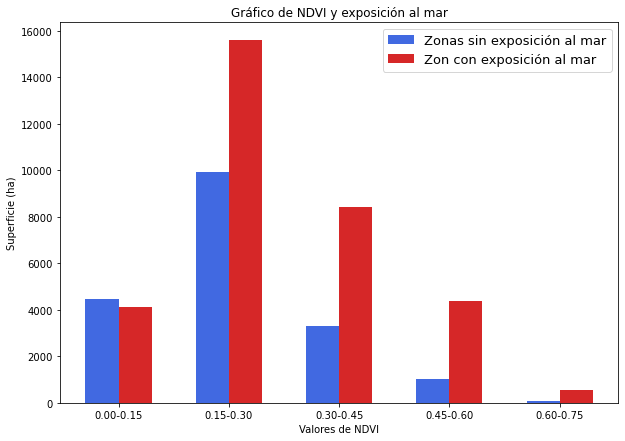

In [39]:
path = r'F:\ConsultoriaPNUD\Data\MapLomas\MOD13Q1_NDVI'
os.chdir(path)

labels = ['0.00-0.15','0.15-0.30', '0.30-0.45', '0.45-0.60', '0.60-0.75']
zonas_sin = [4445.7, 9937.0, 3286.6, 1009.2, 93.9]
zonas_con = [4120.5, 15583.3, 8410.6, 4367.0, 543.7]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, axes = plt.subplots(figsize=(10,7))
rects1 = axes.bar(x - width/2, zonas_sin, width, color = 'royalblue', label='Zonas sin exposición al mar')
rects2 = axes.bar(x + width/2, zonas_con, width, color = 'tab:red', label='Zon con exposición al mar')

# Add some text for labels, title and custom x-axis tick labels, etc.
axes.set_ylabel('Superficie (ha)')
axes.set_xlabel('Valores de NDVI')
axes.set_title('Gráfico de NDVI y exposición al mar')
axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.legend(prop={"size":13})
plt.show()
#plt.savefig('Gráfico_de_NDVI_exposición_al_mar.png')

### 2.5 Correlación entre NDVI y Distancia al mar

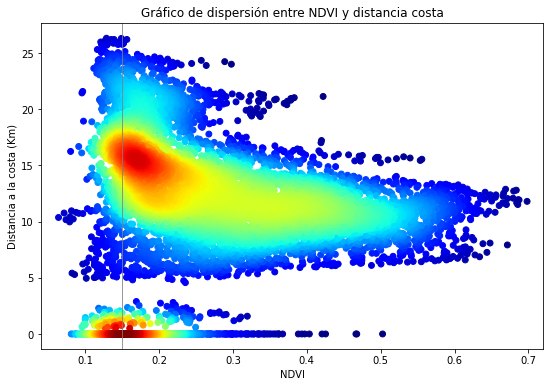

In [41]:
orien = (rasterio.open('Distancia_costa_RegionLoma.tif').read())/1000
ndvi = rasterio.open('NDVI_MEDIA_RegionLomas.tif').read()

n = ndvi.ravel()
m = orien.ravel()
dataFrame = pd.DataFrame({'x':n, 'y':m})
df = dataFrame.dropna()
df = df.loc[(df!=0).any(1)]

x = df.iloc[:,0].values
y = df.iloc[:,1].values

# Calcula la densidad de punto
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Ordena los puntos por densidad
idx = z.argsort()
xi, yi, zi = x[idx], y[idx], z[idx]

fig, axes = plt.subplots(figsize=(9,6))
axes.scatter(xi, yi, c=zi, s=35, cmap='jet')
axes.set_ylabel('Distancia a la costa (Km)')
axes.set_xlabel('NDVI')
axes.set_title('Gráfico de dispersión entre NDVI y distancia costa')
axes.axvline(x =0.15, color='grey', linewidth=0.8)
axes.set_xlim(0.04,0.72)
plt.show()
#plt.savefig('Gráfico_de_NDVI_Distancia_costa.png')

### 2.6 Correlación entre NDVI y Pendiente

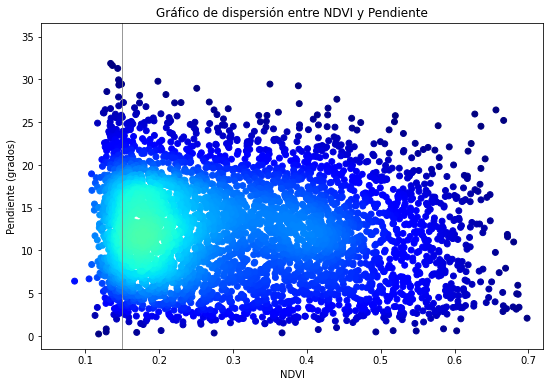

In [57]:
pend = rasterio.open('PENDIENTE_RegionLomas.tif').read()
ndvi = rasterio.open('NDVI_MEDIA_RegionLomas.tif').read()

n = ndvi.ravel()
m = pend.ravel()
dataFrame = pd.DataFrame({'x':n, 'y':m})
df = dataFrame.dropna()
df = df.loc[(df!=0).any(1)]

x = df.iloc[:,0].values
y = df.iloc[:,1].values

# Calcula la densidad de punto
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Ordena los puntos por densidad
idx = z.argsort()
xi, yi, zi = x[idx], y[idx], z[idx]

fig, axes = plt.subplots(figsize=(9,6))
axes.scatter(xi, yi, c=zi, s=35, cmap='jet')
axes.set_ylabel('Pendiente (grados)')
axes.set_xlabel('NDVI')
axes.set_title('Gráfico de dispersión entre NDVI y Pendiente')
axes.axvline(x =0.15, color='grey', linewidth=0.8)
axes.set_xlim(0.04,0.72)
plt.show()
plt.savefig('Gráfico_de_NDVI_Pendiente.png')